# Gemma-Information-Extraction

## Implementation

Creation of an output class to control the model’s response.
The model may detect none, one, or multiple names within a sentence.

In [ ]:
from pydantic import BaseModel
from typing import Optional, List

# Define Pydantic models for the JSON structure
class PersNameItem(BaseModel):
    # Optional list of person names
    PersName: Optional[List[str]] = None

class PlaceNameItem(BaseModel):
    # Optional list of place names
    PlaceName: Optional[List[str]] = None


The `reisen02_filtered.json` file, previously created in `corpus_creation.ipynb`, is defined as `input_json`.
Any JSON files generated in the subsequent extraction steps will be deleted.

**Save previously generated results!**

In [ ]:
import os

input_json = "reisen02_filtered.json"

# Files to be deleted
files_to_delete = ["comparison_results.json", "place_results.json", "name_results.json"]

for file_name in files_to_delete:
    if os.path.exists(file_name):
        os.remove(file_name)
        print(f"{file_name} wurde gelöscht.")
    else:
        print(f"{file_name} existiert nicht.")

comparison_results.json existiert nicht.
place_results.json existiert nicht.
name_results.json existiert nicht.


### Personal Name Extraction

The following instructions did not improve the model’s performance.
In fact, adding them later in the prompt tended to reduce output quality, so they were removed again.

This instruction caused the model to become overly cautious and return empty results even for sentences it could understand.
As a result, valid entities were sometimes omitted.

    - Wenn du einen Satz nicht verstehst, gib eine leere Liste zurück. Das kann vor allem passieren, wenn der Satz nicht in deutscher Sprache ist.
    Beispiel:[
    "Satz": "Tonin wa okai iri naserrimas ka"
    "response":"PersName='None'"]

This rule led the model to incorrectly discard genuine personal names whenever they appeared together with ranks or titles.
Instead of filtering the titles, the model sometimes ignored the actual name.
    
    - Berufsnamen, (Herrscher-)Titel und akademische Grade sind keine Personennamen.
    Beispiel:[
    "Satz": "Nachdem Capitain Morland auf dem Schiffe des Commandeurs das Zeichen gegeben hatte, stieß die Flotte in See."
    "response":"PersName='Morland'"]
    

In [ ]:
import json
import ollama

# JSON-Datei laden
with open(input_json, "r", encoding="utf-8") as f:
    data = json.load(f)

sentences = data["sentences"]

results = []

# iterate through sentences and extract person names
for sentence in sentences:
    # the normalized text and sentence id
    norm_text = sentence["norm_sentence"]["text"]
    sentence_id = sentence["sentence_id"]
    tokens = sentence["norm_sentence"]["tokens"]

    # Create prompt for the model
    prompt = f"""Du bist ein KI-Modell, das auf das Finden von Personennamen spezialisiert ist.
    Deine Aufgabe ist es, aus übergebenen Sätzen alle Personennamen zu extrahieren.
    Achte dabei auf folgendes:
    - Behalte die Originalschreibweise der Namen bei.
    Beispiel:[
        "Satz": "Die kurze Nachricht, welche de la Caille, der im Jahr 1751 nach Cap kam gibt, enthält beinahe nichts anderes, als was er von anderen hörte."
        "response":"PersName='de la Caille'"]
    - Extrahiere wirklich alle Personennamen, lasse keinen aus.
    Beispiel:[
        "Satz": "Unter Herrn Gronovius Mineralien fand ich viele Stufen aus Schweden, die Herr Gother ihm von seinem Gärtner Wittbom geschickt hatte."
        "response":"PersName='Gronovius', PersName='Gother', PersName='Wittbom'"]
    - Ignoriere alle andere Arten von Namen wie Ortsnamen und auch Berufsbezeichnungen, akademische Grade oder Titel.
    Beispiel:[
        "Satz": "Zu Leiden ließ ich mein erstes Geschäft sein, Herrn Professor van Royen zu besuchen, der mir seine kapsche Kräutersammlung zeigt, die er vom Grafen aus Ceylon bekommen hatte."
        "response":"PersName='van Royen'"]
    - Wenn du in einem Satz keine Namen findest, gib eine leere Liste zurück.
    Beispiel:[
        "Satz": "Er ist ein sehr artiger, aufgeweckter und gelehrter Mann."
        "response":"PersName='None'"]

    Satz: {norm_text}
    """

    # Call the model
    response = ollama.chat(
    model='gemma3:12b',
    messages=[
        {"role": "user",
         "content": prompt
        }
    ],
    format=PersNameItem.model_json_schema(),
    )

    name = PersNameItem.model_validate_json(response.message.content)
    print(f"Personennamen Satz {sentence_id}:  {response.message.content}")
    #print(name.PersName)

    extracted_names = []
    if name.PersName and name.PersName != "None":
        for name in name.PersName:
            # Split multi-part terms and add the tokens to the list
            extracted_names.extend(name.split())

    results.append({"sentence_id": sentence_id, "extracted_names": extracted_names})

# Save results to a JSON file
with open("name_results.json", "w", encoding="utf-8") as f:
    json.dump({"results": results}, f, ensure_ascii=False, indent=4)

print("Ergebnisse gespeichert in 'name_results.json'")

Personennamen Satz 0:  {"PersName": ["Karl Peter Thunberg"]}
Personennamen Satz 1:  {"PersName": ["Christian Heinrich Groskurd"]}
Personennamen Satz 2:  {"PersName": ["None"]}
Personennamen Satz 3:  {"PersName": ["None"]}
Personennamen Satz 4:  {"PersName": ["None"]}
Personennamen Satz 5:  {"PersName": ["None"]}
Personennamen Satz 6:  {"PersName": ["Kap", "Holland", "England", "Deutschland", "Schweden"]}
Personennamen Satz 7:  {"PersName": ["None"]}
Personennamen Satz 8:  {"PersName": ["None"]}
Personennamen Satz 9:  {"PersName": ["None"]}
Personennamen Satz 10:  {"PersName": ["None"]}
Personennamen Satz 11:  {"PersName": ["None"]}
Personennamen Satz 12:  {"PersName": ["None"]}
Personennamen Satz 13:  {"PersName": ["None"]}
Personennamen Satz 14:  {"PersName": ["None"]}
Personennamen Satz 15:  {"PersName": ["None"]}
Personennamen Satz 16:  {"PersName": ["None"]}
Personennamen Satz 17:  {"PersName": ["None"]}
Personennamen Satz 18:  {"PersName": ["None"]}
Personennamen Satz 19:  {"PersN

### Ortsnamenextraktion

In [6]:
# JSON-Datei laden
with open(input_json, "r", encoding="utf-8") as f:
    data = json.load(f)

sentences = data["sentences"]

results = []

# Schleife über alle normalisierten Sätze
for sentence in sentences:
    norm_text = sentence["norm_sentence"]["text"]
    sentence_id = sentence["sentence_id"]
    tokens = sentence["norm_sentence"]["tokens"]

    # Prompt für das Modell erstellen
    prompt = f"""Du bist ein KI-Modell, das auf das Finden von Orstnamen spezialisiert ist.
    Deine Aufgabe ist es, aus den übergebenen Sätzen alle Ortsnamen zu extrahieren.
    Achte dabei auf folgendes:
    - Behalte die Originalschreibweise der Namen bei.
    Beispiel:[
        "Satz": "Vom Keureboomsflusse reisten wir durch den Pußpaßfluss nach Zwellendam"
        "response":"PlaceName='Keureboomsflusse', PlaceName='Pußpaßfluss', PlaceName='Zwellendam'"]
    - Extrahiere wirklich alle Ortsnamen, lasse keinen aus.
    Beispiel:[
        "Satz": "Des Verfassers Reise von Stockholm nach dem Vorgebirge der guten Hoffnung, den ersten Aufenthalt zu Cap und die erste Reise nach Afrika."
        "response":"PlaceName='Stockholm', PlaceName='Vorgebirge der guten Hoffnung', PlaceName='Cap', PlaceName='Afrika'"]
    - Ignoriere alle andere Arten von Namen wie Personennamen.
    Beispiel:[
    "Satz": "Zu Leiden ließ ich mein erstes Geschäft sein, Herrn Professor van Royen zu besuchen, der mir seine kapsche Kräutersammlung zeigte."
    "response":"PlaceName='Leiden'"]
    - Wenn du in einem Satz keine Ortsnamen findest, gib eine leere Liste zurück.
        Beispiel:[
        "Satz": "Das Ufer ist sehr steil, springt oft in Landspitzen und Vorgebirgen vor."
        "response":"PersName='None'"]

    Satz: {norm_text}
    """

    # Modell aufrufen
    response = ollama.chat(
    model='gemma3:12b',
    messages=[
        {"role": "user",
         "content": prompt
        }
    ],
    format=PlaceNameItem.model_json_schema(),
    )

    name = PlaceNameItem.model_validate_json(response.message.content)
    print(response.message.content)
    #print(name.PersName)

    extracted_places = []
    if name.PlaceName and name.PlaceName != "None":
        for place in name.PlaceName:
            # Splitte mehrteilige Begriffe und füge die Tokens zur Liste hinzu
            extracted_places.extend(place.split())

    results.append({"sentence_id": sentence_id, "extracted_places": extracted_places})

# Ergebnisse in eine JSON-Datei speichern
with open("place_results.json", "w", encoding="utf-8") as f:
    json.dump({"results": results}, f, ensure_ascii=False, indent=4)

print("Ergebnisse gespeichert in 'place_results.json'")

{"PlaceName": ["Europa", "Afrika", "Asien", "Japan"]}
{"PlaceName": ["Stralsund"]}
{"PlaceName": ["None"]}
{"PlaceName": ["None"]}
{"PlaceName": ["Berlin", "Haude", "Spener"]}
{"PlaceName": ["None"]}
{"PlaceName": ["Batavia", "Japan", "Dezime", "Jedo", "Ceylon", "Kap", "Holland", "England", "Deutschland", "Schweden"]}
{"PlaceName": ["Japan"]}
{"PlaceName": ["Japan"]}
{"PlaceName": ["Land"]}
{"PlaceName": ["None"]}
{"PlaceName": []}

{"PlaceName": []}
{"PlaceName": ["None"]}
{"PlaceName": ["Java", "Ceylon"]}
{"PlaceName": ["None"]}
{"PlaceName": ["None"]}
{"PlaceName": ["Stadt"]}
{"PlaceName": ["None"]}
{"PlaceName": ["None"]}
{"PlaceName": ["None"]}
{"PlaceName": ["None"]}
{"PlaceName": ["None"]}
{"PlaceName": ["None"]}
{"PlaceName": ["Stockholm", "Japan"]}
{"PlaceName": ["Upsala"]}
{"PlaceName": ["None"]}
{"PlaceName": ["None"]}
{"PlaceName": ["None"]}
{"PlaceName": ["Stockholm"]}
{"PlaceName": ["None"]}
{"PlaceName": ["None"]}
{"PlaceName": ["Lund", "Upsala", "Stockholm", "Haarlem", 

## Erstellung Evaluations-Datei

Zunächst noch einmal die Überprüfung, wieviele Personen- und Ortsnamen im Text vorhanden sind.

In [61]:
import json

# JSON-Datei laden
input_json = "reisen02_filtered.json"
with open(input_json, "r", encoding="utf-8") as f:
    data = json.load(f)

# Initialisiere Zähler
total_person_names = 0
total_place_names = 0

# Schleife über alle Sätze
for sentence in data["sentences"]:
    tokens = sentence["norm_sentence"]["tokens"]
    
    # Zähle die Anzahl der Personen- und Ortsnamen
    total_person_names += sum(1 for token in tokens if token.get("entity_type") == "persName")
    total_place_names += sum(1 for token in tokens if token.get("entity_type") == "placeName")

# Ergebnisse ausgeben
print(f"Anzahl der Personennamen: {total_person_names}")
print(f"Anzahl der Ortsnamen: {total_place_names}")

Anzahl der Personennamen: 422
Anzahl der Ortsnamen: 1648


### Erstellung der Evaluationsdatei `comparison_results.json`.

Das Sprachmodell hat in vielen Fällen als leere Liste `None`, manchmal aber auch `[]`zurückgegben.

In [55]:
import json

# Funktion zum Zählen der "None"-Werte in einer JSON-Datei
def count_none_values(file_path, key):
    with open(file_path, "r", encoding="utf-8") as f:
        data = json.load(f)
    
    none_count = 0
    for result in data["results"]:
        none_count += sum(1 for item in result.get(key, []) if item == "None")
    
    return none_count

# Zähle "None"-Werte in place_results.json und name_results.json
place_none_count = count_none_values("place_results.json", "extracted_places")
name_none_count = count_none_values("name_results.json", "extracted_names")

# Ergebnisse ausgeben
print(f"Anzahl der 'None'-Werte in place_results.json: {place_none_count}")
print(f"Anzahl der 'None'-Werte in name_results.json: {name_none_count}")

Anzahl der 'None'-Werte in place_results.json: 3818
Anzahl der 'None'-Werte in name_results.json: 5609


Da im folgenden Code aber nur `[]`als leere Werte akzeptiert werden, müssen `None`-Strings ignoriert werden, da sie sonst die false-positives enorm in die Höhe treiben.
Die von dem LLM extrahierten Personennamen aus der name_results.json werden mit der Ground Truth in der `reisen02_filtered.json` verglichen.

Stimmen die Ergebnisse überein, wird der jeweilige Name in der Liste `hits`gespeichert. Ist der Name nur in der Ground Truth vorhanden, wird er in `missing` abgelegt.
Und wurde ein Name vom LLM identifiziert, der nicht in `reisen02_filtered.json` zu finden ist und der nicht `None`ist, wird er der `false_positive`-Liste hinzugefügt.

In [ ]:
# load JSON files
with open(input_json, "r", encoding="utf-8") as f:
    test_data = json.load(f)

with open("name_results.json", "r", encoding="utf-8") as f:
    results_data = json.load(f)

# Save results
comparison_results = []

# Loop through all sentences in test.json
for sentence in test_data["sentences"]:
    sentence_id = sentence["sentence_id"]
    tokens = sentence["norm_sentence"]["tokens"]

    # Extract persName tokens from test.json
    expected_names = [token["text"] for token in tokens if token.get("entity_type") == "persName"]

    # Find extracted names from results.json
    extracted_names = next((result["extracted_names"] for result in results_data["results"] if result["sentence_id"] == sentence_id), [])

    # Compare names with additional check
    hits = []
    missing = []
    false_positives = []

    for expected_name in expected_names:
        # Direct comparison
        if expected_name in extracted_names:
            hits.append(expected_name)
        else:
            # Remove the last character and compare again
            normalized_expected_name = expected_name[:-1] if len(expected_name) > 1 else expected_name
            match_found = False
            for extracted_name in extracted_names:
                if normalized_expected_name == extracted_name:
                    hits.append(extracted_name)  # Save the extracted name as a hit
                    match_found = True
                    break
            if not match_found:
                missing.append(expected_name)

    # identify false positives
    # false positives are names that are in `extracted_names` but not in `hits` and not "None"
    false_positives = [name for name in extracted_names if name not in hits and name != "None"]

    # Save results
    comparison_results.append({
        "sentence_id": sentence_id,
        "persNames": {
            "hits": hits,
            "missing": missing,
            "false_positives": false_positives
        }
    })

# Save comparison results
with open("comparison_results.json", "w", encoding="utf-8") as f:
    json.dump(comparison_results, f, ensure_ascii=False, indent=4)

print("Vergleichsergebnisse gespeichert in 'comparison_results.json'")

Vergleichsergebnisse gespeichert in 'comparison_results.json'


Selbiges für die Ortsnamen durchgeführt und ebenfalls in der `comparison_results.json` gespeichert.

In [ ]:
# load JSON files
with open(input_json, "r", encoding="utf-8") as f:
    test_data = json.load(f)

with open("place_results.json", "r", encoding="utf-8") as f:
    results_data = json.load(f)

# Load existing comparison_results.json
with open("comparison_results.json", "r", encoding="utf-8") as f:
    comparison_results = json.load(f)

# Loop through all sentences in test.json
for sentence in test_data["sentences"]:
    sentence_id = sentence["sentence_id"]
    tokens = sentence["norm_sentence"]["tokens"]

    # Extract placeName tokens from test.json
    expected_names = [token["text"] for token in tokens if token.get("entity_type") == "placeName"]

    # Find extracted names from place_results.json
    extracted_names = next(
        (result["extracted_places"] for result in results_data["results"] if result["sentence_id"] == sentence_id),
        []
    )

    # Compare names
    hits = [name for name in expected_names if name in extracted_names]
    missing = [name for name in expected_names if name not in extracted_names]
    false_positives = [name for name in extracted_names if name not in expected_names and name != "None"]

    # Update results in comparison_results.json
    for result in comparison_results:
        if result["sentence_id"] == sentence_id:
            result["placeNames"] = {
                "hits": hits,
                "missing": missing,
                "false_positives": false_positives
            }
            break

# Save comparison results
with open("comparison_results.json", "w", encoding="utf-8") as f:
    json.dump(comparison_results, f, ensure_ascii=False, indent=4)

print("Vergleichsergebnisse in 'comparison_results.json' um Ortsnamen erweitert.")

Vergleichsergebnisse in 'comparison_results.json' um Ortsnamen erweitert.


## Evaluations-Skripte

### Ortsnamen

Das Ergebnis für die Ortsnamen:

In [ ]:
import json

# load JSON file
with open("comparison_results.json", "r", encoding="utf-8") as f:
    comparison_results = json.load(f)

# Initialize counters
total_hits = 0
total_missing = 0
total_false_positives = 0

# Loop through all results
for result in comparison_results:
    place_names = result.get("placeNames", {})
    total_hits += len(place_names.get("hits", []))
    total_missing += len(place_names.get("missing", []))
    total_false_positives += len(place_names.get("false_positives", []))

# print results
print("Kennzahlen für Ortsnamen:")
print(f"Treffer (Hits): {total_hits}")
print(f"Fehlende Namen (Missing): {total_missing}")
print(f"Falsch-positive Namen (False Positives): {total_false_positives}")

# Optional: Calculate accuracy
total_expected = total_hits + total_missing
if total_expected > 0:
    accuracy = (total_hits / total_expected) * 100
    print(f"Trefferquote: {accuracy:.2f}%")
else:
    print("Keine erwarteten Namen vorhanden.")

Kennzahlen für Ortsnamen:
Treffer (Hits): 1573
Fehlende Namen (Missing): 75
Falsch-positive Namen (False Positives): 2040
Trefferquote: 95.45%


Ausgabe als Balkendiagramm:

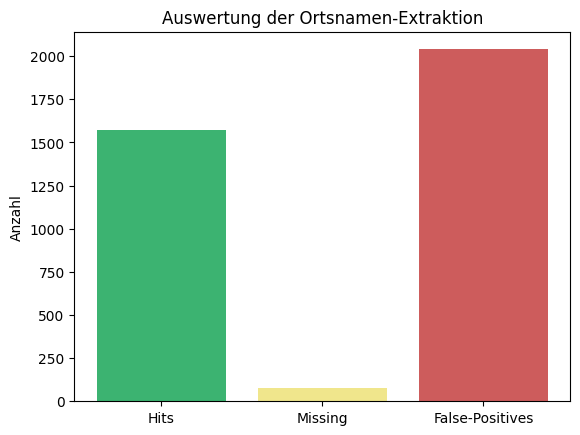

In [ ]:
import matplotlib.pyplot as plt

# clean false positives by removing "None" entries
total_false_positives = sum(
    len([item for item in result.get("placeNames", {}).get("false_positives", []) if item != "None"])
    for result in comparison_results
)

# Data for visualization
categories = ["Hits", "Missing", "False-Positives"]
values = [total_hits, total_missing, total_false_positives]

# Less saturated colors (pastel tones)
colors = ["mediumseagreen", "khaki", "indianred"]

# generate bar chart
plt.bar(categories, values, color=colors, alpha=1)  # alpha reduces saturation
plt.title("Ergebnisse der Ortsnamen-Extraktion")
plt.ylabel("Anzahl")
plt.show()

Ein Ranking der 30 häufigsten `false-positive`-Strings:

In [ ]:
import json
from collections import Counter

# load JSON file
with open("comparison_results.json", "r", encoding="utf-8") as f:
    comparison_results = json.load(f)

# Collect all false positive strings
false_positives = []

for result in comparison_results:
    place_names = result.get("placeNames", {})
    false_positives.extend(place_names.get("false_positives", []))

# Remove empty strings and None values from the list
false_positives = [item for item in false_positives if item and item.strip()]

# Calculate frequency of false positive strings
false_positive_counts = Counter(false_positives)

# Create ranking (sorted by frequency)
ranking = false_positive_counts.most_common()

# output ranking
print("Ranking der Ortsnamen-False-Positive-Strings:")
for string, count in ranking[0:30]:
    print(f"{string}: {count} Vorkommen")

Ranking der Ortsnamen-False-Positive-Strings:
Japan: 113 Vorkommen
Japaner: 110 Vorkommen
Stadt: 52 Vorkommen
Ceylon: 32 Vorkommen
Dairi: 30 Vorkommen
Holländer: 29 Vorkommen
Java: 29 Vorkommen
China: 28 Vorkommen
Insel: 25 Vorkommen
Japanische: 21 Vorkommen
Afrika: 17 Vorkommen
Lande: 17 Vorkommen
Norimon: 17 Vorkommen
Kubo: 17 Vorkommen
Faktorei: 16 Vorkommen
Städten: 16 Vorkommen
Chinesen: 15 Vorkommen
Bergen: 14 Vorkommen
Holländern: 13 Vorkommen
Berge: 13 Vorkommen
Japanern: 11 Vorkommen
Compagnie: 11 Vorkommen
Malabar: 11 Vorkommen
Küste: 10 Vorkommen
Hafen: 10 Vorkommen
Chinese: 10 Vorkommen
Provinz: 10 Vorkommen
Europa: 10 Vorkommen
Holländische: 10 Vorkommen
Holländischen: 9 Vorkommen


Absteigend sortierte Missing-Strings für die Ortsnamen

In [ ]:
import json
from collections import Counter

# load JSON file
with open("comparison_results.json", "r", encoding="utf-8") as f:
    comparison_results = json.load(f)

# Collect all false positive strings
false_positives = []

for result in comparison_results:
    place_names = result.get("placeNames", {})
    false_positives.extend(place_names.get("missing", []))

# Remove empty strings and None values from the list
false_positives = [item for item in false_positives if item and item.strip()]

# Calculate frequency of false positive strings
false_positive_counts = Counter(false_positives)

# Create ranking (sorted by frequency)
ranking = false_positive_counts.most_common()

# output ranking
print("Ranking der Missing-Strings:")
for string, count in ranking[0:30]:
    print(f"{string}: {count} Vorkommen")

Ranking der Missing-Strings:
Europa: 13 Vorkommen
Kopping.: 5 Vorkommen
Dezime: 3 Vorkommen
Asiens: 3 Vorkommen
dem: 3 Vorkommen
Mia: 2 Vorkommen
Japaner: 2 Vorkommen
Juana: 2 Vorkommen
Cap.: 2 Vorkommen
Vorgebirges: 2 Vorkommen
Ceylonern: 2 Vorkommen
Stridesberg: 1 Vorkommen
Mia.: 1 Vorkommen
Meerenge: 1 Vorkommen
Atjar: 1 Vorkommen
Swota: 1 Vorkommen
Jokaits: 1 Vorkommen
jama: 1 Vorkommen
mure: 1 Vorkommen
Tindingawa: 1 Vorkommen
Fusi: 1 Vorkommen
Osi: 1 Vorkommen
Europa's: 1 Vorkommen
Palankine: 1 Vorkommen
Ostindiens: 1 Vorkommen
Bugo: 1 Vorkommen
Japan: 1 Vorkommen
Japanischen: 1 Vorkommen
Nangasacki: 1 Vorkommen
Gold-: 1 Vorkommen


Ausgabe der Missing-Strings mit den False-Positives-Strings im jeweiligen Satz

In [ ]:
import json

# load JSON file
with open("comparison_results.json", "r", encoding="utf-8") as f:
    comparison_results = json.load(f)

# Collect results
missing_with_false_positives = []

for result in comparison_results:
    place_names = result.get("placeNames", {})
    missing = place_names.get("missing", [])
    false_positives = place_names.get("false_positives", [])
    
    # For each missing name, add the false positives from the same sentence
    for missing_name in missing:
        missing_with_false_positives.append({
            "missing_name": missing_name,
            "false_positives": false_positives
        })

# print results
print("Missing-Namen mit zugehörigen False-Positives:")
for entry in missing_with_false_positives:
    print(f"Missing: {entry['missing_name']}, False-Positives: {entry['false_positives']}")

Missing-Namen mit zugehörigen False-Positives:
Missing: Stridesberg, False-Positives: ['Japan']
Missing: Dezime, False-Positives: ['Stadt']
Missing: Mia., False-Positives: ['Mia']
Missing: Meerenge, False-Positives: []
Missing: Atjar, False-Positives: []
Missing: Europa, False-Positives: ['Grönländisches']
Missing: Swota, False-Positives: []
Missing: Jokaits, False-Positives: ['Jokait']
Missing: Mia, False-Positives: ['Bukt', 'See']
Missing: Mia, False-Positives: []
Missing: jama, False-Positives: []
Missing: mure, False-Positives: []
Missing: Tindingawa, False-Positives: []
Missing: Europa, False-Positives: []
Missing: Europa, False-Positives: []
Missing: Europa, False-Positives: ['Japanische']
Missing: Dezime, False-Positives: []
Missing: Fusi, False-Positives: []
Missing: Dezime, False-Positives: []
Missing: Osi, False-Positives: []
Missing: Europa's, False-Positives: ['Europa']
Missing: Japaner, False-Positives: []
Missing: Europa, False-Positives: []
Missing: Europa, False-Positiv

Missing-Strings mit zugehörigen Sätzen.

In [ ]:
import json

# load JSON files
with open("comparison_results.json", "r", encoding="utf-8") as f:
    comparison_results = json.load(f)

with open("reisen02_filtered.json", "r", encoding="utf-8") as f:
    test_data = json.load(f)

# Collect results
missing_with_sentences = []

for result in comparison_results:
    sentence_id = result["sentence_id"]
    place_names = result.get("placeNames", {})
    missing = place_names.get("missing", [])
    
    # load the sentence from the original file
    sentence = next((s["norm_sentence"]["text"] for s in test_data["sentences"] if s["sentence_id"] == sentence_id), "Satz nicht gefunden")
    
    # provide the sentence for each missing name
    for missing_name in missing:
        missing_with_sentences.append({
            "missing_name": missing_name,
            "sentence_id": sentence_id,
            "sentence": sentence
        })

# print results
print("Missing-Namen mit zugehörigen Sätzen:")
for entry in missing_with_sentences:
    print(f"Missing: {entry['missing_name']}, Sentence ID: {entry['sentence_id']}, Satz: {entry['sentence']}")

Missing-Namen mit zugehörigen Sätzen:
Missing: Stridesberg, Sentence ID: 37, Satz: Tal vid praesidii nedläggande Stockholmska Vetenskaps Akademien, om Japanska Nationen, ( Rede bei Niederlegung des Präsidiums in der Akademie der Wissenschaften zu Stockholm, Nachrichten von der japanischen Nation enthaltend, den 3. November 1784, ins deutsche übersetzt von Stridesberg, Frankfurt 1785.
Missing: Dezime, Sentence ID: 319, Satz: Gefundene Gewächse: unter anderen Erdäpfel, Kartoffeln, Bohnen, Erbsen, Buchweizen, Ingber, Spanischer Pfeffer, Tobak, Kalmuswurzel, Bamborohr u. a. Lebensart der Holländer auf Dezime: Einsamkeit und Eingeschränktheit; Zeitvertreibe; Japanische Bedienung; Speisen; Fischgerichte; ( von einem giftigen Fische ); Wohnung; Tisch und Ausgaben; Gebrauch und Unterhaltung Japanischer Lustmädchen aus der Stadt.
Missing: Mia., Sentence ID: 404, Satz: Wasserreise bis Mia. Beschreibung der Stadt.
Missing: Meerenge, Sentence ID: 694, Satz: Wir kamen teils mit wenig Wind, teils mi

Skript, das die zu den False-Positive_Strings gehörigen Sätze ausgibt.
String kann mit Variable `top_false_positive` angepasst werden.

In [ ]:
import json

# load JSON files
with open("comparison_results.json", "r", encoding="utf-8") as f:
    comparison_results = json.load(f)

with open("reisen02_filtered.json", "r", encoding="utf-8") as f:
    test_data = json.load(f)

# Manually set the false positive place name
top_false_positive = "Afrika"  # replace this value with the desired place name

# Find all sentences containing the false positive place name
sentences_with_top_false_positive = []

for result in comparison_results:
    sentence_id = result["sentence_id"]
    place_names = result.get("placeNames", {})
    if top_false_positive in place_names.get("false_positives", []):
        # load the sentence from the original file
        sentence = next((s["norm_sentence"]["text"] for s in test_data["sentences"] if s["sentence_id"] == sentence_id), "Satz nicht gefunden")
        sentences_with_top_false_positive.append({"sentence_id": sentence_id, "sentence": sentence})

# print results
print(f"Alle Sätze mit dem False-Positive-Ortsnamen '{top_false_positive}':")
for entry in sentences_with_top_false_positive:
    print(f"Sentence ID: {entry['sentence_id']}, Satz: {entry['sentence']}")

Alle Sätze mit dem False-Positive-Ortsnamen 'Afrika':
Sentence ID: 67, Satz: 20. Medicina Africanorum Resp.
Sentence ID: 101, Satz: 45. Museum naturale academiae Upsaliensis, P X. Resp. Kugelberg 1791.
Sentence ID: 116, Satz: 2. Beskrifning pa en besynnertig auch obekant Svamp, Hydnora Africana.
Sentence ID: 117, Satz: ( Beschreibung eines besonderen und unbekannten Schwamms, Hydnora Africana ), 1775. 1 Qu. S. 69. 1 Kupfertafel.
Sentence ID: 124, Satz: 6. Anmärkningar vid Hydnora africana.
Sentence ID: 125, Satz: ( Anmerkungen zur afrikanischen Hydnore ), 1777. 2 Qu. S. 144. 1 K. T.
Sentence ID: 2226, Satz: Nach ihrer Zurückkunft nach China und erhaltener Nachricht von diesem Vorfalle wurden nachher andere Portugiesen, nebst Missionarien dahin geschickt.
Sentence ID: 5479, Satz: Sonderbarer Vorfall mit einem afrikanischen Zwiebelgewächse.
Sentence ID: 5840, Satz: Das Christentum wurde in Japan, sogleich nach der Entdeckung dieses Landes, von den Portugiesen eingeführt.
Sentence ID: 623

Ausgabe der Sätze mit höchster Fehlerzahl.

In [ ]:
# find sentences with the most errors
error_analysis = []

for result in comparison_results:
    sentence_id = result["sentence_id"]
    place_names = result.get("placeNames", {})
    total_errors = len(place_names.get("missing", [])) + len(place_names.get("false_positives", []))
    error_analysis.append((sentence_id, total_errors))

# Sort by number of errors
error_analysis.sort(key=lambda x: x[1], reverse=True)

# top 5 sentences with the most errors
print("Top 5 Sätze mit den meisten Fehlern:")
for sentence_id, errors in error_analysis[:5]:
    # Lade den Satz aus der Originaldatei
    sentence = next((s["norm_sentence"]["text"] for s in test_data["sentences"] if s["sentence_id"] == sentence_id), "Satz nicht gefunden")
    extracted_places = next((r["extracted_places"] for r in results_data["results"] if r["sentence_id"] == sentence_id), [])
    
    print(f"Sentence ID: {sentence_id}, Fehler: {errors}")
    print(f"Satz: {sentence}")
    print(f"Extrahierte Ortsnamen: {extracted_places}\n")

Top 5 Sätze mit den meisten Fehlern:
Sentence ID: 223, Fehler: 123
Satz: Inhalt.
Extrahierte Ortsnamen: ['München', 'Berlin', 'Hamburg', 'Leipzig', 'Dresden', 'München', 'Nürnberg', 'Frankfurt', 'Köln', 'Stuttgart', 'Düsseldorf', 'Dortmund', 'Essen', 'Bremen', 'Dresden', 'Halle', 'Magdeburg', 'Kiel', 'Rostock', 'Stralsund', 'Wismar', 'Schwerin', 'Erfurt', 'Weimar', 'Jena', 'Potsdam', 'Bonn', 'Mannheim', 'Wiesbaden', 'Münster', 'Bielefeld', 'Chemnitz', 'Karlsruhe', 'Braunschweig', 'Krefeld', 'Freiburg', 'Mainz', 'Lübeck', 'Augsburg', 'Wuppertal', 'Hannover', 'Duisburg', 'Bochum', 'Würzburg', 'Oldenburg', 'Erfurt', 'Regensburg', 'Gotha', 'Pforzheim', 'Saarbrücken', 'Wolfsburg', 'Kassel', 'Hildesheim', 'Mönchengladbach', 'Luxemburg', 'Belgien', 'Niederlande', 'Österreich', 'Schweiz', 'Tschechien', 'Polen', 'Frankreich', 'Italien', 'Spanien', 'Portugal', 'Griechenland', 'Rumänien', 'Bulgarien', 'Ungarn', 'Slowakei', 'Kroatien', 'Serbien', 'Albanien', 'Türkei', 'Russland', 'Ukraine', 'Weißr

### Person Names

Results for the Person Names:

In [ ]:
import json

# load JSON file
with open("comparison_results.json", "r", encoding="utf-8") as f:
    comparison_results = json.load(f)

# Initialize counters
total_hits = 0
total_missing = 0
total_false_positives = 0

# Loop through all results
for result in comparison_results:
    pers_names = result.get("persNames", {})
    total_hits += len(pers_names.get("hits", []))
    total_missing += len(pers_names.get("missing", []))
    total_false_positives += len(pers_names.get("false_positives", []))

# print results
print("Kennzahlen für Personennamen:")
print(f"Treffer (Hits): {total_hits}")
print(f"Fehlende Namen (Missing): {total_missing}")
print(f"Falsch-positive Namen (False Positives): {total_false_positives}")

# Optional: calculate accuracy
total_expected = total_hits + total_missing
if total_expected > 0:
    accuracy = (total_hits / total_expected) * 100
    print(f"Trefferquote: {accuracy:.2f}%")
else:
    print("Keine erwarteten Namen vorhanden.")

Kennzahlen für Personennamen:
Treffer (Hits): 394
Fehlende Namen (Missing): 28
Falsch-positive Namen (False Positives): 885
Trefferquote: 93.36%


Visualization

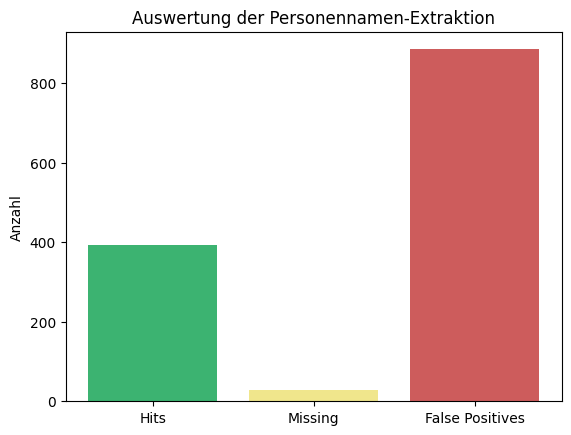

In [ ]:
import matplotlib.pyplot as plt

# data for visualization
categories = ["Hits", "Missing", "False Positives"]
values = [total_hits, total_missing, total_false_positives]

# create bar chart
plt.bar(categories, values, color=["mediumseagreen", "khaki", "indianred"])
plt.title("Auswertung der Personennamen-Extraktion")
plt.ylabel("Anzahl")
plt.show()

In [ ]:
import json
from collections import Counter

# load JSON file
with open("comparison_results.json", "r", encoding="utf-8") as f:
    comparison_results = json.load(f)

# Collect all false positive strings
false_positives = []

for result in comparison_results:
    place_names = result.get("persNames", {})
    false_positives.extend(place_names.get("missing", []))

# Calculate frequency of false positive strings
false_positive_counts = Counter(false_positives)

# Create ranking (sorted by frequency)
ranking = false_positive_counts.most_common()

# output ranking
print("Ranking der Missing-Strings:")
for string, count in ranking[0:30]:  # Top 10 Ergebnisse
    print(f"{string}: {count} Vorkommen")

Ranking der Missing-Strings:
Kämpfer: 5 Vorkommen
Kämpfers: 2 Vorkommen
Capitain: 2 Vorkommen
Jesu: 2 Vorkommen
Christi: 2 Vorkommen
Bergackern: 2 Vorkommen
Berg.: 1 Vorkommen
Bjerken: 1 Vorkommen
Gallen: 1 Vorkommen
Schalen: 1 Vorkommen
Hast: 1 Vorkommen
Holmer: 1 Vorkommen
Lagus: 1 Vorkommen
je: 1 Vorkommen
no: 1 Vorkommen
Banks: 1 Vorkommen
den: 1 Vorkommen
dreyzehnten: 1 Vorkommen
Zimmt-Capitain: 1 Vorkommen


In [ ]:
import json

# load JSON file
with open("comparison_results.json", "r", encoding="utf-8") as f:
    comparison_results = json.load(f)

# Collect results
missing_with_false_positives = []

for result in comparison_results:
    place_names = result.get("persNames", {})
    missing = place_names.get("missing", [])
    false_positives = place_names.get("false_positives", [])
    
    # For each missing name, add the false positives from the same sentence
    for missing_name in missing:
        missing_with_false_positives.append({
            "missing_name": missing_name,
            "false_positives": false_positives
        })

# print results
print("Missing-Namen mit zugehörigen False-Positives:")
for entry in missing_with_false_positives:
    print(f"Missing: {entry['missing_name']}, False-Positives: {entry['false_positives']}")

Missing-Namen mit zugehörigen False-Positives:
Missing: Berg., False-Positives: []
Missing: Bjerken, False-Positives: []
Missing: Gallen, False-Positives: ['P.', 'V.', 'Resp.']
Missing: Schalen, False-Positives: []
Missing: Hast, False-Positives: []
Missing: Holmer, False-Positives: []
Missing: Lagus, False-Positives: ['P']
Missing: Kämpfers, False-Positives: []
Missing: Kämpfer, False-Positives: []
Missing: Kämpfer, False-Positives: []
Missing: je, False-Positives: ['Saffioge']
Missing: no, False-Positives: ['Saffioge']
Missing: Banks, False-Positives: []
Missing: Kämpfer, False-Positives: ['Kubo']
Missing: Kämpfer, False-Positives: []
Missing: den, False-Positives: []
Missing: dreyzehnten, False-Positives: []
Missing: Kämpfer, False-Positives: []
Missing: Kämpfers, False-Positives: []
Missing: Capitain, False-Positives: []
Missing: Zimmt-Capitain, False-Positives: []
Missing: Jesu, False-Positives: ['Matthaeus']
Missing: Christi, False-Positives: ['Matthaeus']
Missing: Jesu, False-Po

A ranking of the 30 most frequent `false-positive` strings:

In [ ]:
import json
from collections import Counter

# load JSON file
with open("comparison_results.json", "r", encoding="utf-8") as f:
    comparison_results = json.load(f)

# Collect all false positive strings
false_positives = []

for result in comparison_results:
    place_names = result.get("persNames", {})
    false_positives.extend(place_names.get("false_positives", []))

# Calculate frequency of false positive strings
false_positive_counts = Counter(false_positives)

# Create ranking (sorted by frequency)
ranking = false_positive_counts.most_common()

# output ranking
print("Ranking der Personennamen-False-Positive-Strings:")
for string, count in ranking[0:30]:  # Top 10 Ergebnisse
    print(f"{string}: {count} Vorkommen")

Ranking der Personennamen-False-Positive-Strings:
Kubo: 21 Vorkommen
Dairi: 15 Vorkommen
Jedo: 14 Vorkommen
Kaiser: 14 Vorkommen
Gouverneur: 11 Vorkommen
Kapitän: 10 Vorkommen
Simonoseki: 8 Vorkommen
Ambassadeur: 8 Vorkommen
Juana: 8 Vorkommen
Kronprinz: 6 Vorkommen
Chef: 6 Vorkommen
Ottone: 6 Vorkommen
Dezime: 5 Vorkommen
Miako: 5 Vorkommen
Kronprinzen: 5 Vorkommen
Curundu: 5 Vorkommen
P.: 4 Vorkommen
Kapitäns: 4 Vorkommen
von: 4 Vorkommen
Papenberg: 4 Vorkommen
Resp.: 3 Vorkommen
Mia: 3 Vorkommen
Sekretär: 3 Vorkommen
Fürsten: 3 Vorkommen
der: 3 Vorkommen
Seki: 3 Vorkommen
Batavia: 3 Vorkommen
Gale: 3 Vorkommen
Kaneel: 3 Vorkommen
Dai: 3 Vorkommen


Search for specific False-Positive-Person-Names

In [ ]:
import json

# load JSON files
with open("comparison_results.json", "r", encoding="utf-8") as f:
    comparison_results = json.load(f)

with open("reisen02_filtered.json", "r", encoding="utf-8") as f:
    test_data = json.load(f)

# Manually set the false positive name
top_false_positive = "Simonoseki"  # replace this value with the desired name

# find all sentences containing the false positive name
sentences_with_top_false_positive = []

for result in comparison_results:
    sentence_id = result["sentence_id"]
    pers_names = result.get("persNames", {})
    if top_false_positive in pers_names.get("false_positives", []):
        # Load the sentence from the original file
        sentence = next((s["norm_sentence"]["text"] for s in test_data["sentences"] if s["sentence_id"] == sentence_id), "Satz nicht gefunden")
        sentences_with_top_false_positive.append({"sentence_id": sentence_id, "sentence": sentence})

# print results
print(f"Alle Sätze mit dem False-Positive-Personennamen '{top_false_positive}':")
for entry in sentences_with_top_false_positive:
    print(f"Sentence ID: {entry['sentence_id']}, Satz: {entry['sentence']}")

Alle Sätze mit dem False-Positive-Personennamen 'Simonoseki':
Sentence ID: 373, Satz: Reise zu Wasser nach Simonoseki; Aufenthalt daselbst; Beschreibung der Stadt.
Sentence ID: 1339, Satz: Ein großer Teil Sachen aber wird zur See nach Simonoseki, Fiogo und anderen Orten geschickt.
Sentence ID: 1341, Satz: Dies Fahrzeug sollte zuerst nach Simonoseki gehen, und nach unserer Ankunft daselbst, auch unsere Personen nach Fiogo überführen.
Sentence ID: 1460, Satz: Gegen Abend fuhren wir mit einer Jacht drei Meilen weit über den Meerbusen nach Simonoseki, wo wir in einem Wirtshause übernachteten.
Sentence ID: 1478, Satz: Von Simonoseki geht zwar zu Lande ein Weg nach Jedo; wir bedienten uns dessen aber nicht, weil er gebirgig und beschwerlich ist, sondern zogen die Wasserreise vor.
Sentence ID: 2195, Satz: Hier schickten wir uns zu der bevor stehenden weiten Seereise an, und schifften uns auf das gewöhnliche große Fahrzeug ein, das uns nach Simonoseki bringen sollte.
Sentence ID: 2977, Satz: S

Missing names with their corresponding sentences:

In [ ]:
import json

# load JSON files
with open("comparison_results.json", "r", encoding="utf-8") as f:
    comparison_results = json.load(f)

with open("reisen02_filtered.json", "r", encoding="utf-8") as f:
    test_data = json.load(f)

# Collect results
missing_with_sentences = []

for result in comparison_results:
    sentence_id = result["sentence_id"]
    place_names = result.get("persNames", {})
    missing = place_names.get("missing", [])
    
    # load the sentence from the original file
    sentence = next((s["norm_sentence"]["text"] for s in test_data["sentences"] if s["sentence_id"] == sentence_id), "Satz nicht gefunden")
    
    # provide the sentence for each missing name
    for missing_name in missing:
        missing_with_sentences.append({
            "missing_name": missing_name,
            "sentence_id": sentence_id,
            "sentence": sentence
        })

# print results
print("Missing-Namen mit zugehörigen Sätzen:")
for entry in missing_with_sentences:
    print(f"Missing: {entry['missing_name']}, Sentence ID: {entry['sentence_id']}, Satz: {entry['sentence']}")

Missing-Namen mit zugehörigen Sätzen:
Missing: Berg., Sentence ID: 68, Satz: Berg. 1785.
Missing: Bjerken, Sentence ID: 74, Satz: 26. -- -- -- -- P. IV. Resp. Bjerken 1787. 1 Tabb.
Missing: Gallen, Sentence ID: 75, Satz: 27. -- -- -- -- P. V. Resp. Gallen 1787.
Missing: Schalen, Sentence ID: 77, Satz: 29. Museum naturale academiae Upsaliensisi, P. VI. Resp. Schalen 1788. 1 Tab.
Missing: Hast, Sentence ID: 87, Satz: Hast.
Missing: Holmer, Sentence ID: 96, Satz: Holmer 1790.
Missing: Lagus, Sentence ID: 100, Satz: 44. Novae insectorum species, P. VI Resp. Lagus 1791.
Missing: Kämpfers, Sentence ID: 1362, Satz: Zu Kämpfers Zeiten mußten die beiden letzteren reiten, und Kälte, Regen und Wind sich gefallen lassen.
Missing: Kämpfer, Sentence ID: 1406, Satz: Als Kämpfer im Jahr 1691 diese Reise machte, nahm die Gesandtschaft einen anderen Weg nach Sinongi, nämlich über den Meerbusen bei Omura.
Missing: Kämpfer, Sentence ID: 1692, Satz: Strömlinge, diese in der Ost-See allenthalben, sonst sehr

Script that prints the sentences corresponding to the `False_Positive_Strings`.

The string to be checked can be adjusted via the variable `top_false_positive`.

Outputs the sentences with the highest error counts.

In [ ]:
# load JSON files
with open("name_results.json", "r", encoding="utf-8") as f:
    results_data = json.load(f)

# Find sentences with the most errors for person names
error_analysis = []

for result in comparison_results:
    sentence_id = result["sentence_id"]
    pers_names = result.get("persNames", {})
    total_errors = len(pers_names.get("missing", [])) + len(pers_names.get("false_positives", []))
    error_analysis.append((sentence_id, total_errors))

# Sort by number of errors
error_analysis.sort(key=lambda x: x[1], reverse=True)

# top 5 sentences with the most errors
print("Top 5 Sätze mit den meisten Fehlern für Personennamen:")
for sentence_id, errors in error_analysis[:5]:
    # load the sentence from the original file
    sentence = next((s["norm_sentence"]["text"] for s in test_data["sentences"] if s["sentence_id"] == sentence_id), "Satz nicht gefunden")
    extracted_names = next((r["extracted_names"] for r in results_data["results"] if r["sentence_id"] == sentence_id), [])
    
    print(f"Sentence ID: {sentence_id}, Fehler: {errors}")
    print(f"Satz: {sentence}")
    print(f"Extrahierte Personennamen: {extracted_names}\n")

Top 5 Sätze mit den meisten Fehlern für Personennamen:
Sentence ID: 7100, Fehler: 126
Satz: Hier sind ihre Namen: der japanische und der Vielfleck-Sonnenkäfer ( Coccinella japonica, quadripustulata ); das Sonnenhähnchen und das Weidenhähnchen ( Chrysomela aestuans, pallida ); der Totenfreund ( Dermestes violaceus ); der Japanische- und der Ketten-Sandläufer ( Cicindela japonica, catena ); der Kupferschmied ( Scarabaeus aeruginosus, japanisch Fama Musi ); der europäische Dungkäfer ( Hefter unicolor ); der großnasige Erdfloh und der Stachelfloh ( Mordella nasuta, aculeata ); der Kräuterdieb ( Ptinus für ); der Zwitterkäfer ( Malve proscarabaeus ); der Blaustrich und der Blasenschildkäfer ( Cassida nobilis, vesicularis ); der Blumenkratzer aus dem Geschlecht der Totengräber ( Sylpha aestiva ); der Bauer, die Feuerglut, der zierliche und der Haubenstinkkäfer ( Buprestis rustica, ignita, elegans, vittata ); das Stachelhorn ( Cerambyx rubus ); der japanische und der platte leuchtende Käfer (

For example, in sentence 1598 the model identified several tokens both as place names and as personal names.
The names themselves were recognized correctly, but they were assigned to the wrong category.

The same issue occurs in sentence 1633.
Sentence 1648 shows a similar pattern, although here the model correctly extracted 20 place names and only 15 incorrect personal names. This suggests that some names were classified correctly as locations, or at least not misclassified as personal names.

This also supports the assumption that the missing names in the final list were not simply dropped—for example due to memory limitations—since the five missing names occur at different positions rather than being cut off at the end of the output.
